### Lossely based on Lecture 3 (https://github.com/karpathy/nn-zero-to-hero)
- ##### I fit randomly generated data
- ##### I use an MLP with one output neuron
- ##### I use Binary Crossentropy as loss function

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [71]:
num_examples = 1000
num_features = 3

g = torch.Generator().manual_seed(2147483647)
xtrain = torch.randn(num_examples,num_features,generator=g) # random data
y0 = torch.zeros(int(num_examples/2))
y1 = torch.ones(int(num_examples/2))
shuffle = torch.randperm(num_examples,generator=g) 
ytrain = torch.cat((y0,y1),dim=0)[shuffle] # random labels
xtrain.shape, ytrain.shape

(torch.Size([1000, 3]), torch.Size([1000]))

In [72]:
# validation set
val_examples = 100

g = torch.Generator().manual_seed(0) # diaforetiko seed giana parw diaforetika data
xval = torch.randn(val_examples,num_features,generator=g) # random test data

val_y0 = torch.zeros(int(val_examples/2))
val_y1 = torch.ones(int(val_examples/2))
shuffle = torch.randperm(val_examples,generator=g) 
yval = torch.cat((val_y0,val_y1),dim=0)[shuffle] # random labels 
xval.shape, yval.shape

(torch.Size([100, 3]), torch.Size([100]))

In [283]:
# Neural Net parameters
layers = [nn.Linear(num_features,20,bias=False),nn.Tanh(),
          nn.Linear(20,20,bias=False)          ,nn.Tanh(),
          nn.Linear(20,20,bias=False)          ,nn.Tanh(),
          nn.Linear(20,20,bias=False)          ,nn.Tanh(),
          nn.Linear(20,1,bias=False) ]

# torch.manual_seed(0) # gia na pernw sinexeia ta idia weights!
with torch.no_grad():
  nn.init.kaiming_normal_(layers[-1].weight,nonlinearity='sigmoid')
  layers[-1].weight.data *= 0.1 # gia to arxiko loss
  for layer in layers[:-1]:
    if isinstance(layer,nn.Linear):
      nn.init.kaiming_normal_(layer.weight.data,nonlinearity='tanh') # nmzw to nonlinearity kathorizei to gain!

In [284]:
parameters = [p for layer in layers for p in layer.parameters()]
complexity = sum(p.nelement() for p in parameters)  # i measure model complexity just as the number of parameters
complexity

1280

In [285]:
# lr selection
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [286]:
# so that i can run backbrop
for p in parameters:
  p.requires_grad = True

In [287]:
epochs = 100000
batch_size = 32
lri = []
lossi = []
ud = [] # update:data ratio

for i in tqdm(range(epochs)):
  layer_out = [] # gia na kanw to .out opws to exwei o karpathy!
  
  # minbach construct
  ix = torch.randint(0,xtrain.shape[0],(batch_size,))
  x = xtrain[ix]
  
  # forward pass
  for layer in layers:
    x = layer(x)
    x.retain_grad() 
    layer_out.append(x)
  loss = F.binary_cross_entropy_with_logits(x.view(-1),ytrain[ix]) # mallon pio numericaly stable?
  
  # backward pass 
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
#   lr = lrs[i]
  lr = 0.09 # decay the lr?
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
#   lri.append(lre[i])
  lossi.append(loss.log10().item())
  # print(loss.item())
  if i>1000:
    break # DEBUG

  1%|▎                                   | 1001/100000 [00:01<01:58, 836.37it/s]


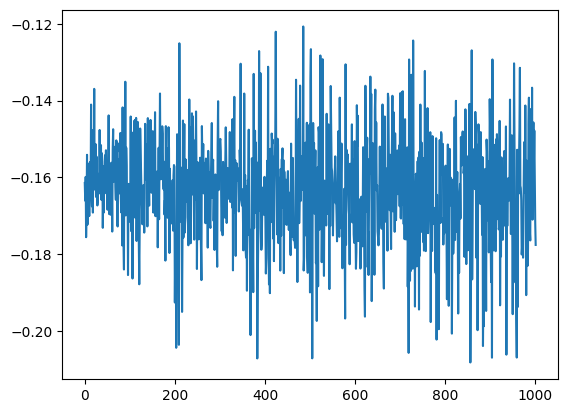

In [288]:
plt.plot(lossi);

In [289]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (xtrain,ytrain),
    'val': (xval,yval)
  }[split]
  for layer in layers:
    x = layer(x)
  loss = F.binary_cross_entropy_with_logits(x.view(-1), y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 0.681951642036438
val 0.7008533477783203


layer 1 (      Tanh): mean -0.04, std 0.73, saturated: 20.78%
layer 3 (      Tanh): mean +0.05, std 0.68, saturated: 8.44%
layer 5 (      Tanh): mean +0.07, std 0.65, saturated: 6.41%
layer 7 (      Tanh): mean -0.01, std 0.62, saturated: 4.38%


Text(0.5, 1.0, 'activation distribution')

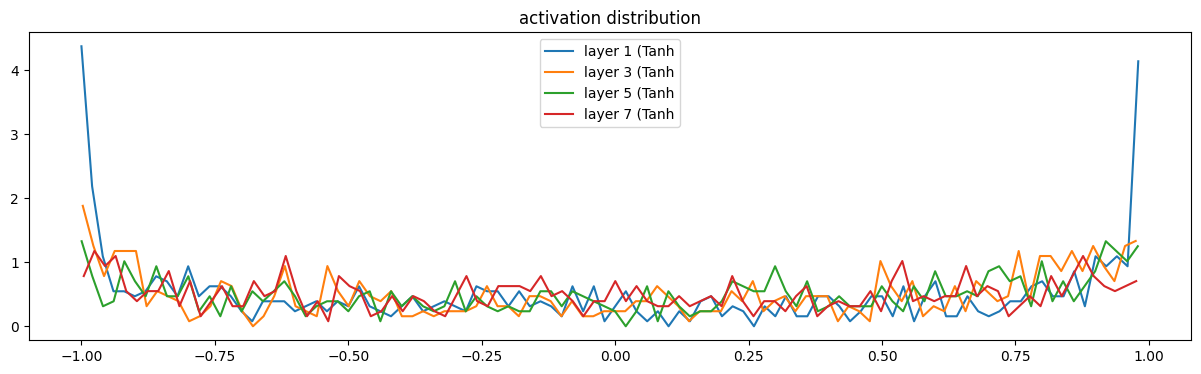

In [290]:
# visualize histograms
plt.figure(figsize=(15, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer_out[i]
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000005, std 2.742012e-03
layer 3 (      Tanh): mean +0.000050, std 2.579431e-03
layer 5 (      Tanh): mean -0.000055, std 2.757286e-03
layer 7 (      Tanh): mean -0.000023, std 1.906263e-03


Text(0.5, 1.0, 'gradient distribution')

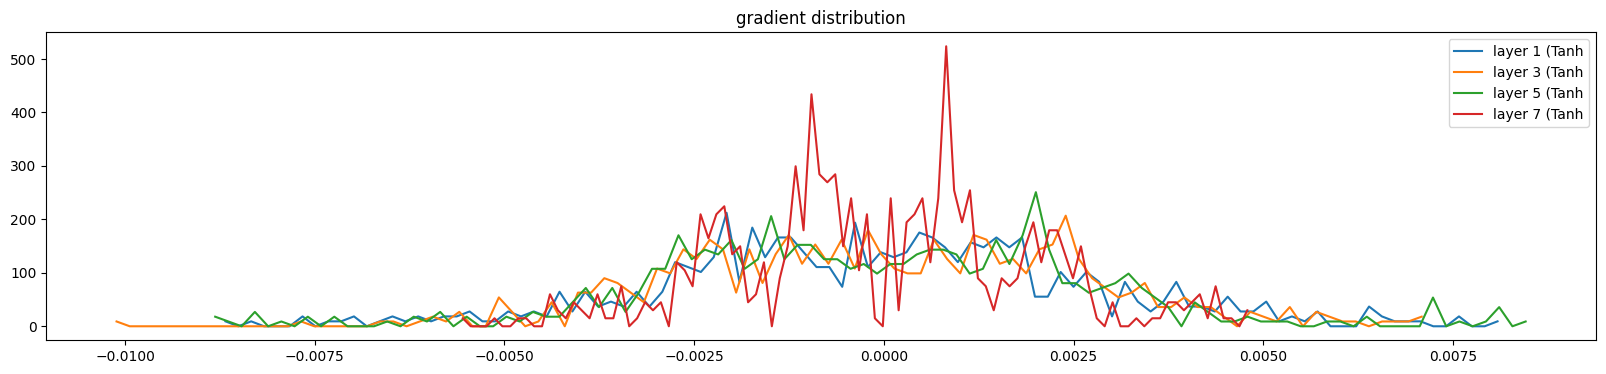

In [291]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, nn.Tanh):
    t = layer_out[i].grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight    (20, 3) | mean +0.000937 | std 6.450506e-03 | grad:data ratio 6.606787e-03
weight   (20, 20) | mean +0.000045 | std 5.662091e-03 | grad:data ratio 1.551502e-02
weight   (20, 20) | mean +0.000748 | std 6.911051e-03 | grad:data ratio 1.905813e-02
weight   (20, 20) | mean +0.000540 | std 5.073657e-03 | grad:data ratio 1.428944e-02
weight    (1, 20) | mean -0.016120 | std 4.918261e-02 | grad:data ratio 4.079852e-01


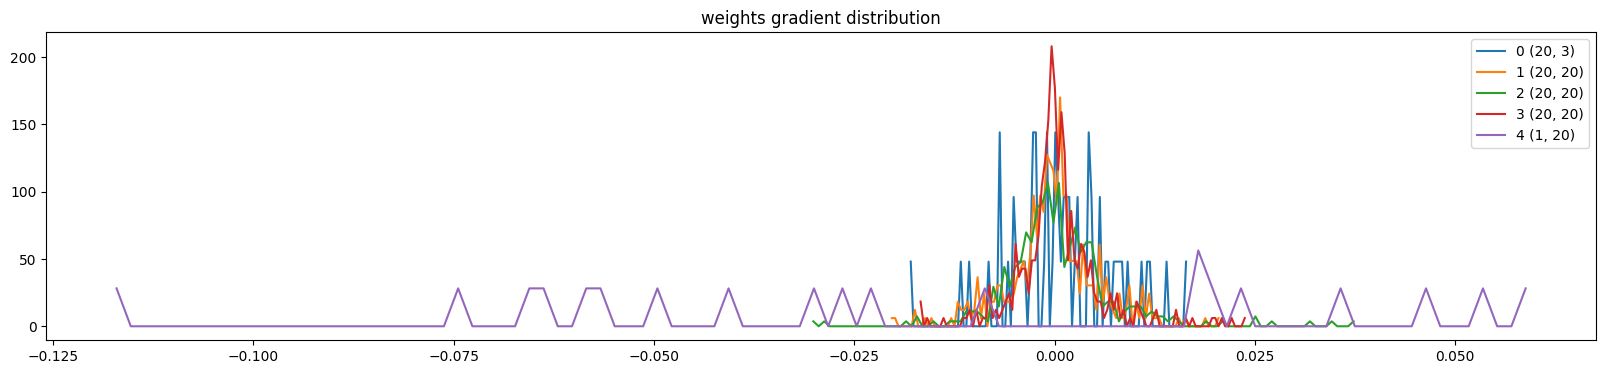

In [292]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

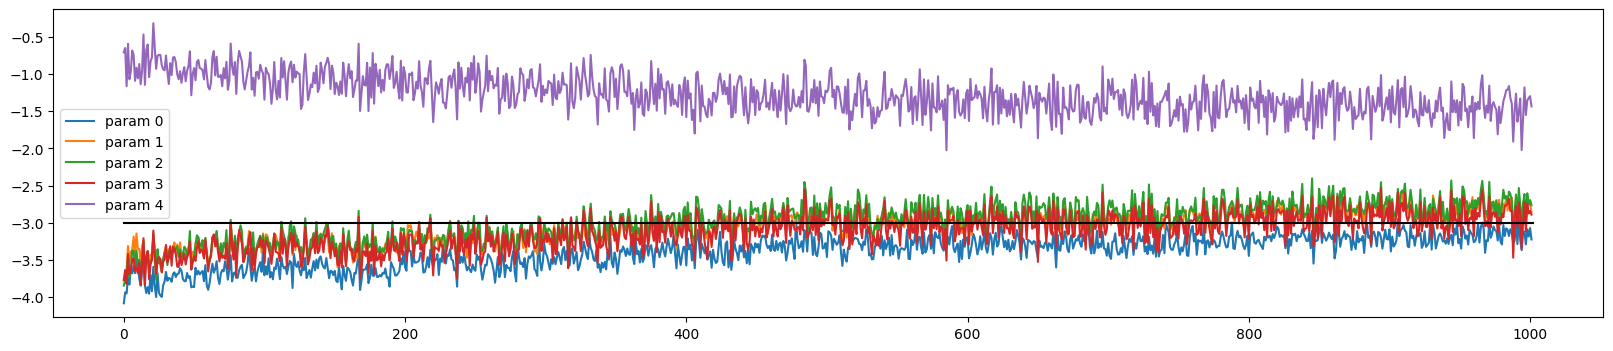

In [293]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

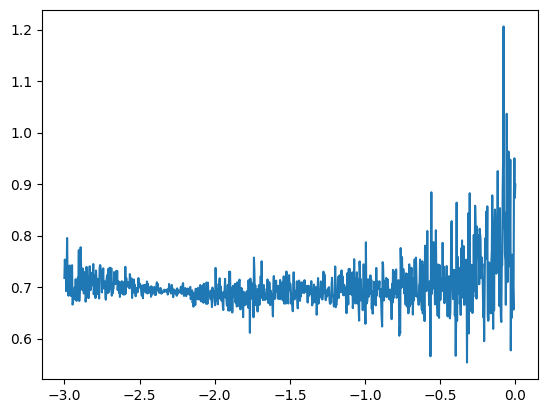

In [9]:
# lr selection
plt.plot(lri,lossi);